In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


import mlflow
from mlflow.models import infer_signature


In [3]:
df = pd.read_csv('Fraud_data/Fraud.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [6]:
# Separate the fraud and non-fraud cases
df_fraud = df[df.isFraud == 1]
df_non_fraud = df[df.isFraud == 0]

# undersampling on the non-fraud cases
df_non_fraud_undersampled = df_non_fraud.sample(n=len(df_fraud)*2, random_state=42)

# Combine the fraud cases with the undersampled non-fraud cases
df_balanced = pd.concat([df_fraud, df_non_fraud_undersampled])

# Shuffle 
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
df_balanced.isFraud.value_counts()

isFraud
0    16426
1     8213
Name: count, dtype: int64

In [8]:
# Encode categorical variables
label_encoder = LabelEncoder()
df_balanced['type'] = label_encoder.fit_transform(df_balanced['type'])
df_balanced['nameOrig'] = label_encoder.fit_transform(df_balanced['nameOrig'])
df_balanced['nameDest'] = label_encoder.fit_transform(df_balanced['nameDest'])

# Fill missing values
df.fillna({'oldbalanceDest': 0}, inplace=True)
df.fillna({'oldbalanceDest': 0}, inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','nameOrig','nameDest']
df_balanced[numerical_features] = scaler.fit_transform(df_balanced[numerical_features])

# Define features and target
features = df_balanced.drop(columns=['isFraud', 'isFlaggedFraud',"step"])
target = df_balanced['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to numpy arrays for easier handling
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class FraudDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

class FraudDetectionModel(nn.Module):
    def __init__(self, num_numerical_features, num_types, embedding_dim=32):
        super(FraudDetectionModel, self).__init__()
        self.type_embedding = nn.Embedding(num_types, embedding_dim)
        
        self.fc1 = nn.Linear(17, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        type_embedded = self.type_embedding(x[:, 0].long())

        
        x_numerical = x[:, [ 1,2, 3,4, 5, 6,7]]
        
        x = torch.cat([x_numerical, type_embedded], dim=1)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x


In [11]:
# Number of unique values for embeddings
num_types = df_balanced['type'].nunique()


# Prepare datasets and dataloaders
train_dataset = FraudDataset(X_train, y_train)
test_dataset = FraudDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
from training_utils import evaluate_models
evaluate_models(X_train, X_test, y_train, y_test)

Logistic Regression Accuracy: 0.916599025974026
Decision Tree Accuracy: 0.9924918831168831
Random Forest Accuracy: 0.9935064935064936
SVM Accuracy: 0.9170048701298701


----------------------- Model Eval on Test data -----------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3303
           1       0.98      1.00      0.99      1625

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



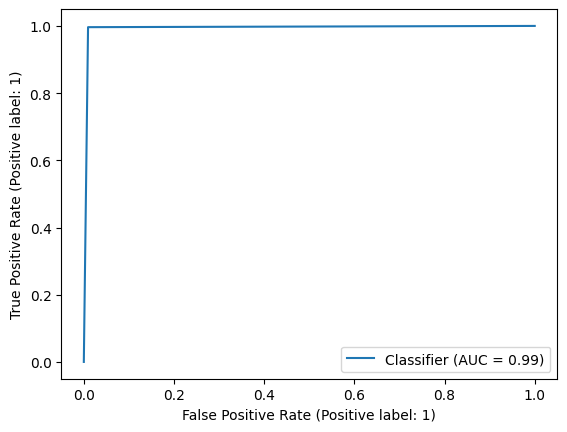

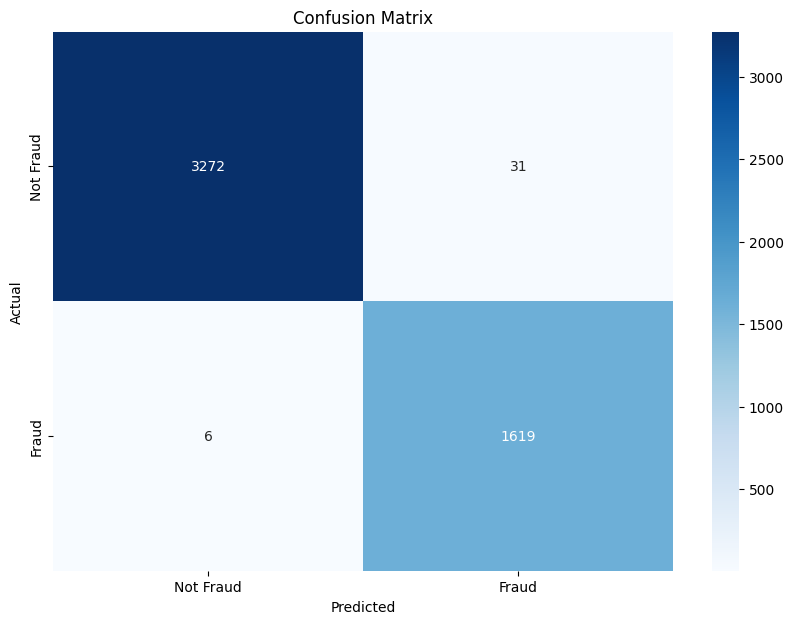

In [13]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
# Random Forest

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)

print("----------------------- Model Eval on Test data -----------------------")

# Classification Report
print(classification_report(y_test, y_pred_random_forest))
conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_random_forest)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
accuracy = random_forest.score(X_test, y_test)

## MLflow


In [17]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://localhost:5000") #mlflow ui --host 0.0.0.0

# Create a new MLflow Experiment
mlflow.set_experiment("FraudDetection")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    #mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic Random Forest model for Finance Fraud Detection")

    # Infer the model signature
    signature = infer_signature(X_train, random_forest.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=random_forest,
        artifact_path="RF_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

2024/08/19 15:07:35 INFO mlflow.tracking.fluent: Experiment with name 'FraudDetection' does not exist. Creating a new experiment.
Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
2024/08/19 15:07:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 2
Created version '2' of model 'tracking-quickstart'.


2024/08/19 15:07:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-shoat-647 at: http://localhost:5000/#/experiments/366208296114052816/runs/7a3df956ea3045afa54e4386182a2172.
2024/08/19 15:07:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/366208296114052816.


In [ ]:
y_pred_random_forest = random_forest.predict(X_test)


In [11]:
# Ensure CUDA is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to the device (GPU)
model = FraudDetectionModel(num_numerical_features=9, 
    num_types=num_types, 
    embedding_dim=10).to(device)
model

Using device: cuda


FraudDetectionModel(
  (type_embedding): Embedding(5, 10)
  (fc1): Linear(in_features=17, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
total_param = 0
for param in model.parameters():
    print(param.size())
    total_param+=len(param)
print(total_param)

torch.Size([5, 10])
torch.Size([64, 17])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
199


In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    if epoch%10 ==0:   
        print(f'Epoch {epoch+10}/{epochs}, Loss: {running_loss/len(train_loader)}')



c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

ROC AUC: 0.9971153496821072
Precision: 0.983085250338295
Recall: 0.8941538461538462
F1 Score: 0.9365130518852722
Confusion Matrix:
[[3278   25]
 [ 172 1453]]
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      3303
         1.0       0.98      0.89      0.94      1625

    accuracy                           0.96      4928
   macro avg       0.97      0.94      0.95      4928
weighted avg       0.96      0.96      0.96      4928



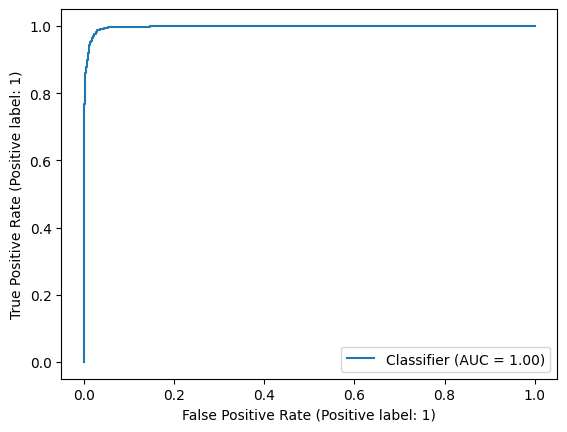

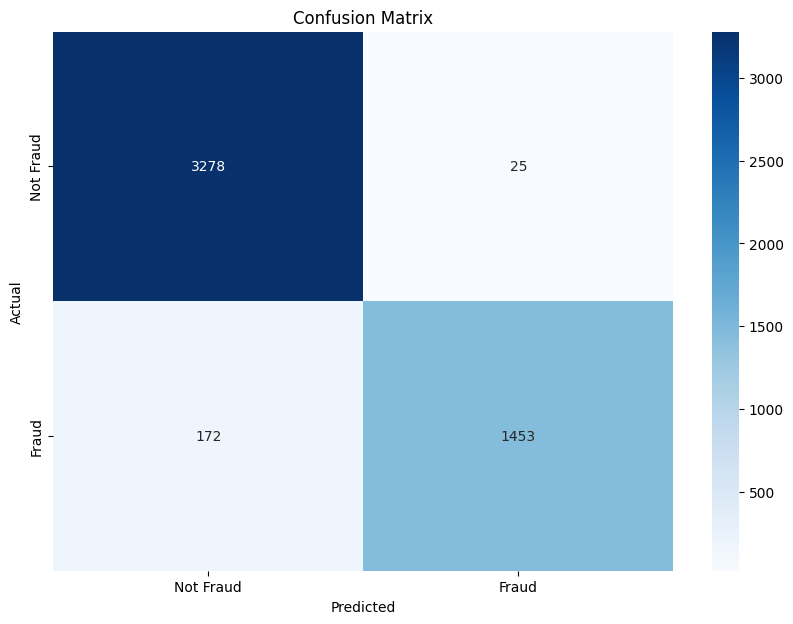

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Metrics
roc_auc = roc_auc_score(all_labels, all_probs)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print(classification_report(all_labels, all_preds))

# ROC Curve
RocCurveDisplay.from_predictions(all_labels, all_probs)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ROC AUC: 0.9911940194229022
Precision: 0.9596503026227303
Recall: 0.8781538461538462
F1 Score: 0.9170951156812339



Confusion Matrix:
[[3243   60]
 [ 198 1427]]

 
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      3303
         1.0       0.96      0.88      0.92      1625

    accuracy                           0.95      4928
   macro avg       0.95      0.93      0.94      4928
weighted avg       0.95      0.95      0.95      4928


              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      3303
         1.0       0.98      0.89      0.94      1625

    accuracy                           0.96      4928
   macro avg       0.97      0.94      0.95      4928
weighted avg       0.96      0.96      0.96      4928

In [21]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [27]:
df['type'] = label_encoder.fit_transform(df['type'])
df['nameOrig'] = label_encoder.fit_transform(df['nameOrig'])
df['nameDest'] = label_encoder.fit_transform(df['nameDest'])

# Fill missing values
df.fillna({'oldbalanceDest': 0}, inplace=True)
df.fillna({'oldbalanceDest': 0}, inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','nameOrig','nameDest']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Define features and target
features = df.drop(columns=['isFraud', 'isFlaggedFraud',"step"])
target = df['isFraud']



In [28]:
from sklearn.metrics import accuracy_score

pred_all = random_forest.predict(features)
print(accuracy_score(target, pred_all))

c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7425285495597725


ROC AUC: 0.8692130726287218
Precision: 0.004969799750234459
Recall: 0.9962254961646171
F1 Score: 0.009890260655873446
Confusion Matrix:
[[4716245 1638162]
 [     31    8182]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85   6354407
           1       0.00      1.00      0.01      8213

    accuracy                           0.74   6362620
   macro avg       0.50      0.87      0.43   6362620
weighted avg       1.00      0.74      0.85   6362620



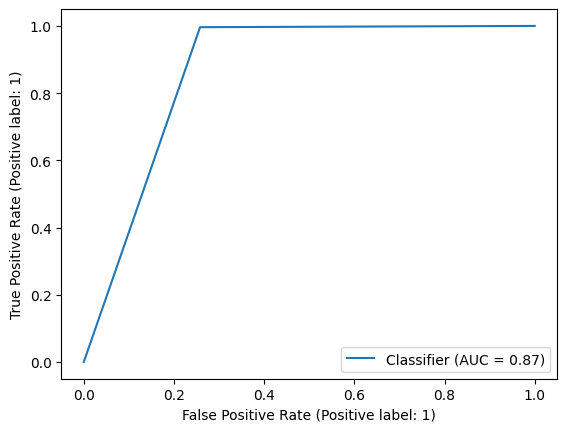

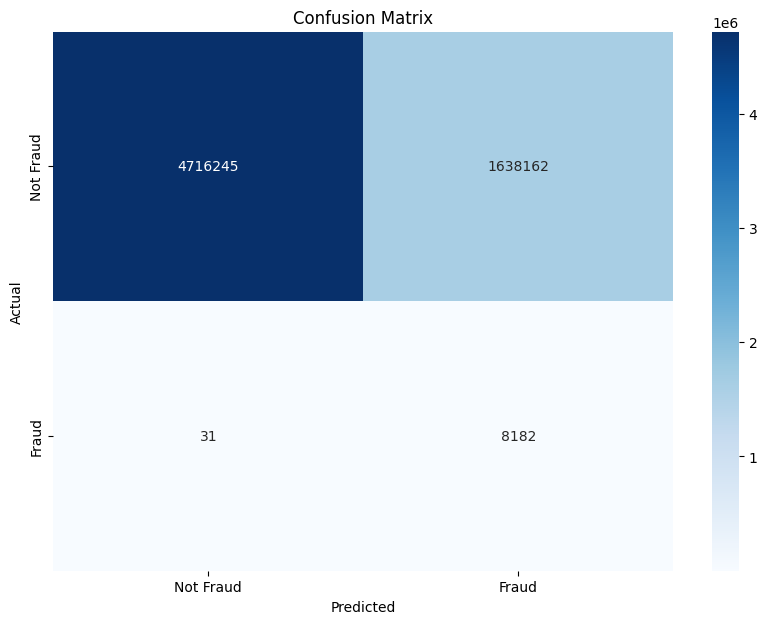

In [30]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
conf_matrix = confusion_matrix(target, pred_all)
roc_auc = roc_auc_score(target, pred_all)
precision = precision_score(target, pred_all)
recall = recall_score(target, pred_all)
f1 = f1_score(target, pred_all)
conf_matrix = confusion_matrix(target, pred_all)

print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print(classification_report(target, pred_all))

# ROC Curve
RocCurveDisplay.from_predictions(target, pred_all)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


----------------------- Model Eval on Test data -----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.75      0.85      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



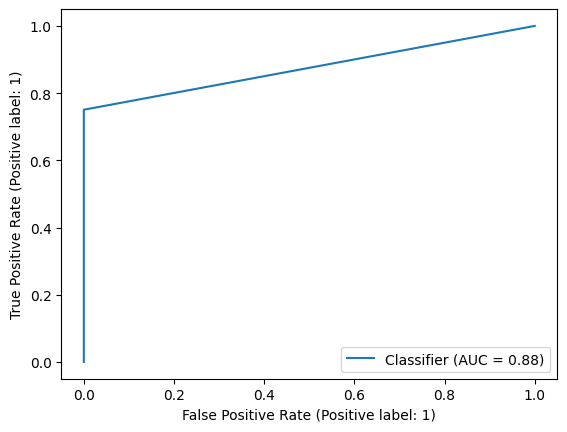

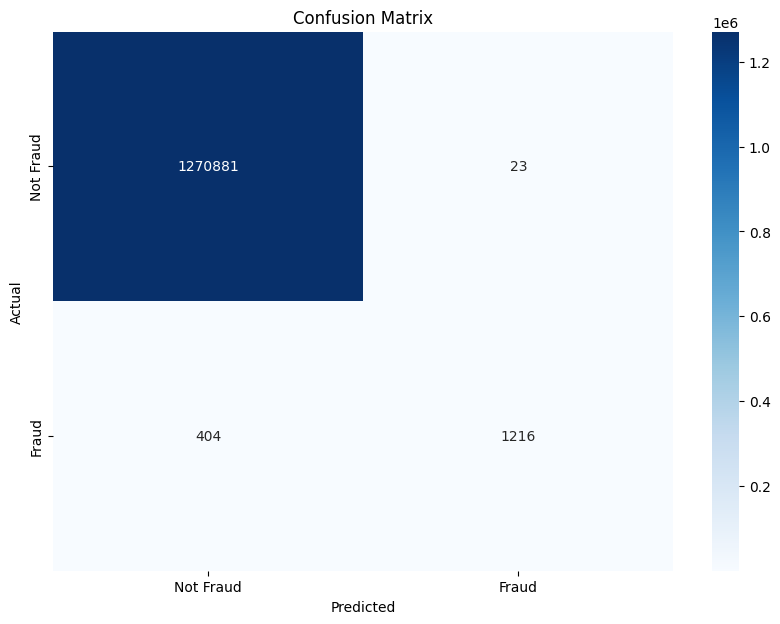

In [31]:
()
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)

print("----------------------- Model Eval on Test data -----------------------")

# Classification Report
print(classification_report(y_test, y_pred_random_forest))
conf_matrix = confusion_matrix(y_test, y_pred_random_forest)
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_random_forest)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# model_path = 'Models/fraud_detection_RF_model_0.99ac.pth'
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

Model saved to Models/fraud_detection_RF_model_0.99ac.pth


In [ ]:
# Load the model
model2 = FraudDetectionModel(
    num_numerical_features=7, 
    num_types=num_types, 
    embedding_dim=10
)
model2.load_state_dict(torch.load(model_path))

print("Model loaded successfully")


Model loaded successfully
